In [7]:
from PIL import Image
import os
import cv2
import pathlib
import imghdr
import subprocess as sp
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.image import ResizeMethod
import tensorflow_datasets as tfds

from sklearn.metrics import accuracy_score

# 데이터 가져오기

In [2]:
flower_li = os.listdir('./images')
flower_li.remove('.DS_Store')
flower_li

['버드나무',
 '목련',
 '해바라기',
 '노루오줌',
 '참나리',
 '은행나무',
 '무궁화',
 '할미꽃',
 '단풍나무',
 '꽃향유',
 '물봉선',
 '작약',
 '봉선화',
 '진달래',
 '동백나무',
 '산딸나무',
 '패랭이꽃',
 '수국',
 '토끼풀',
 '국화',
 '은방울꽃',
 '각시붓꽃',
 '밤나무',
 '노루귀',
 '측백나무',
 '수선화',
 '꽃아까시나무',
 '소나무',
 '층꽃나무',
 '벚나무']

In [39]:
data_dir = './data_directory/'

data_directory = pathlib.Path(data_dir)
image_count = len(list(data_directory.glob('*/*.jpg'))) + len(list(data_directory.glob('*/*.jpeg')))

In [40]:
image_count

10382

In [41]:
list_ds = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [42]:
for f in list_ds.take(5):
    print(f.numpy())

b'./data_directory/magnolia/80.jpg'
b'./data_directory/touch_me_not/506.jpg'
b'./data_directory/dogwood/323.jpg'
b'./data_directory/dogwood/207.jpg'
b'./data_directory/pine/407.jpg'


In [43]:
class_names = np.array(sorted([item.name for item in data_directory.glob('*') if item.name != ".DS_Store"]))
print(class_names)

['astilbe_rubra' 'azalea' 'balsam' 'camellia' 'caryopteris'
 'cherry_blossom' 'chestnut' 'chrysanthemum' 'clover' 'daffodil'
 'dianthus' 'dogwood' 'ginkgo' 'hepatica' 'hydrangea' 'iris'
 'lily_of_the_valley' 'magnolia' 'maple_tree' 'pasqueflower' 'peony'
 'pine' 'rose_acacia' 'rose_of_sharon' 'shiny_mint' 'sunflower' 'thuja'
 'tiger_lily' 'touch_me_not' 'willow']


In [44]:
flower_dic = {}

In [45]:
len(class_names)

30

# 데이터 전처리

In [81]:
img_height = 224
img_width = 224
batch_size=32

In [97]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [98]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

8306
2076


In [96]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    try:
        img = tf.io.decode_jpeg(img, channels=3)
    except:
        img = tf.io.decode_bmp(img, chennels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

## 파일 확장자 확인코드
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                    bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

In [64]:
source_dir = data_dir
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  azalea
processing class directory  peony
processing class directory  cherry_blossom
processing class directory  pasqueflower


Invalid SOS parameters for sequential JPEG


processing class directory  balsam
processing class directory  dianthus
processing class directory  .DS_Store
*** WARNING*** you have files in  ./data_directory/  it should only contain sub directories
processing class directory  rose_acacia
processing class directory  hepatica
processing class directory  clover
processing class directory  rose_of_sharon
processing class directory  iris
processing class directory  maple_tree
processing class directory  dogwood
processing class directory  chestnut


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


processing class directory  caryopteris
processing class directory  chrysanthemum


libpng warning: iCCP: known incorrect sRGB profile


processing class directory  shiny_mint
processing class directory  pine
processing class directory  tiger_lily
processing class directory  camellia


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


processing class directory  ginkgo
processing class directory  thuja


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


processing class directory  astilbe_rubra
processing class directory  hydrangea
processing class directory  touch_me_not


Corrupt JPEG data: 37 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 63 extraneous bytes before marker 0xd9
Corrupt JPEG data: 63 extraneous bytes before marker 0xd9
Corrupt JPEG data: 60 extraneous bytes before marker 0xd9
Corrupt JPEG data: 37 extraneous bytes before marker 0xd9


processing class directory  magnolia
processing class directory  sunflower
processing class directory  lily_of_the_valley
processing class directory  daffodil
processing class directory  willow
 no improper image files were found


In [32]:
for i in bad_file_list:
    !ls {i}

ls: ./data_directory/azalea/189.jpg: No such file or directory
ls: ./data_directory/azalea/189.jpg: No such file or directory
ls: ./data_directory/azalea/89.jpg: No such file or directory
ls: ./data_directory/azalea/76.jpg: No such file or directory
ls: ./data_directory/azalea/148.jpg: No such file or directory
ls: ./data_directory/azalea/.DS_Store: No such file or directory
ls: ./data_directory/azalea/.DS_Store: No such file or directory
ls: ./data_directory/azalea/64.jpg: No such file or directory
ls: ./data_directory/azalea/73.jpg: No such file or directory
ls: ./data_directory/azalea/17.jpg: No such file or directory
ls: ./data_directory/azalea/102.jpg: No such file or directory
ls: ./data_directory/azalea/11.jpg: No such file or directory
ls: ./data_directory/azalea/137.jpg: No such file or directory
ls: ./data_directory/azalea/143.jpg: No such file or directory
ls: ./data_directory/peony/48.jpg: No such file or directory
ls: ./data_directory/peony/.DS_Store: No such file or direc

ls: ./data_directory/dogwood/358.jpg: No such file or directory
ls: ./data_directory/dogwood/129.jpg: No such file or directory
ls: ./data_directory/dogwood/115.jpg: No such file or directory
ls: ./data_directory/dogwood/459.jpg: No such file or directory
ls: ./data_directory/dogwood/260.jpg: No such file or directory
ls: ./data_directory/dogwood/243.jpg: No such file or directory
ls: ./data_directory/dogwood/451.jpg: No such file or directory
ls: ./data_directory/dogwood/20.jpg: No such file or directory
ls: ./data_directory/dogwood/318.jpg: No such file or directory
ls: ./data_directory/dogwood/522.jpg: No such file or directory
ls: ./data_directory/dogwood/133.jpg: No such file or directory
ls: ./data_directory/dogwood/285.jpg: No such file or directory
ls: ./data_directory/dogwood/340.jpg: No such file or directory
ls: ./data_directory/dogwood/381.jpg: No such file or directory
ls: ./data_directory/dogwood/178.jpg: No such file or directory
ls: ./data_directory/dogwood/79.jpg: No s

ls: ./data_directory/hydrangea/404.jpg: No such file or directory
ls: ./data_directory/hydrangea/376.jpg: No such file or directory
ls: ./data_directory/hydrangea/170.jpg: No such file or directory
ls: ./data_directory/hydrangea/.DS_Store: No such file or directory
ls: ./data_directory/hydrangea/.DS_Store: No such file or directory
ls: ./data_directory/hydrangea/9.jpg: No such file or directory
ls: ./data_directory/hydrangea/28.jpg: No such file or directory
ls: ./data_directory/hydrangea/315.jpg: No such file or directory
ls: ./data_directory/hydrangea/294.jpg: No such file or directory
ls: ./data_directory/hydrangea/268.jpg: No such file or directory
ls: ./data_directory/hydrangea/132.jpg: No such file or directory
ls: ./data_directory/hydrangea/292.jpg: No such file or directory
ls: ./data_directory/hydrangea/133.jpg: No such file or directory
ls: ./data_directory/hydrangea/133.jpg: No such file or directory
ls: ./data_directory/hydrangea/327.jpg: No such file or directory
ls: ./dat

In [29]:
for l in bad_file_list:
    print(sp.getstatusoutput(f"rm {l}"))

(1, 'rm: ./data_directory/azalea/189.jpg: No such file or directory')
(1, 'rm: ./data_directory/azalea/189.jpg: No such file or directory')
(0, '')
(0, '')
(0, '')
(0, '')
(1, 'rm: ./data_directory/azalea/.DS_Store: No such file or directory')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(1, 'rm: ./data_directory/peony/.DS_Store: No such file or directory')
(0, '')
(0, '')
(0, '')
(1, 'rm: ./data_directory/cherry_blossom/175.jpg: No such file or directory')
(0, '')
(0, '')
(1, 'rm: ./data_directory/cherry_blossom/.DS_Store: No such file or directory')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(1, 'rm: ./data_directory/pasqueflower/.DS_Store: No such file or directory')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '')
(1, 'rm: ./data_directory/pasqueflower/141.jpg: No such file or directory')
(0, '')
(0, '')
(0, '')
(0, '')
(0, '

In [99]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [100]:
len(train_ds)

8306

In [101]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [102]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Corrupt JPEG data: 37 extraneous bytes before marker 0xd9
2022-06-16 18:28:43.938689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-06-16 18:28:43.938705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


Image shape:  (32, 224, 224, 3)
Label:  [ 1 17 13  8 21  2 13 10 25 16 23 15 28 22 21 13  7 11 22  0 28 28  8  5
 13 16 22 15  1 22 23  9]


2022-06-16 18:28:45.384091: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Corrupt JPEG data: 37 extraneous bytes before marker 0xd9
2022-06-16 18:27:01.618799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-06-16 18:27:01.618816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2022-06-16 18:27:03.038671: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


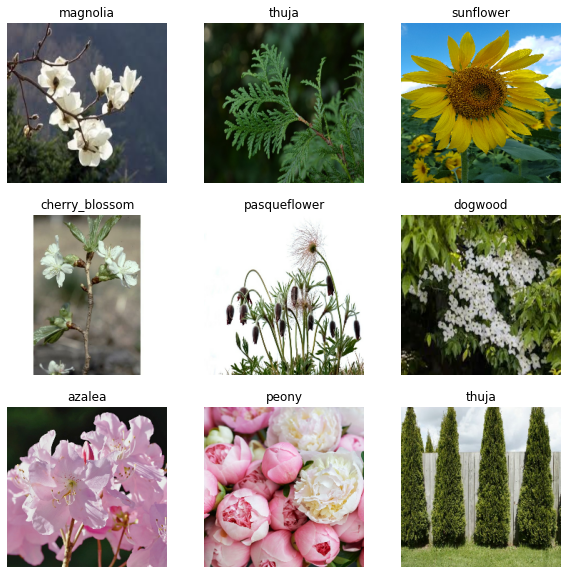

In [88]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [89]:
len(class_names)

30

# 모델

In [103]:
num_classes = len(class_names)
num_classes

30

In [ ]:
## 모델 build error
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3, 3), 
                         input_shape=(img_height, img_width, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [55]:
from tensorflow.keras import datasets, layers, models, activations

In [104]:
model = models.Sequential()
model.add(layers.Convolution2D(32, (3, 3), 
                               activation=activations.relu, 
                               padding='same',
                               input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

In [105]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 200704)           

In [106]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [94]:
epochs = 10

## 모델 학습

In [107]:
history = model.fit(train_ds, epochs=epochs, 
                    validation_data=val_ds)

Epoch 1/10


2022-06-16 18:28:57.367375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 37 extraneous bytes before marker 0xd9
2022-06-16 18:28:58.563059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-06-16 18:28:58.563160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


  3/260 [..............................] - ETA: 49s - loss: 1266.4004 - accuracy: 0.0312 

2022-06-16 18:29:00.440312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-06-16 18:29:00.440326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 45/260 [====>.........................] - ETA: 33s - loss: 112.5007 - accuracy: 0.0458

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_12]]
  (1) INVALID_ARGUMENT:  Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_4405]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 모델 평가

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

# 모델 테스트

In [ ]:
test_dir = 'test_images/'
test_directory = pathlib.Path(test_dir)
test_images = os.listdir(test_dir)
test_images.remove('.DS_Store')
test_images_cnt = len(test_images)

test_ds = tf.data.Dataset.list_files(str(test_dir+'*/*'), shuffle=False)
test_ds = test_ds.shuffle(test_images_cnt, reshuffle_each_iteration=False)

In [ ]:
test_images

In [ ]:
for f in test_ds.take(5):
    print(f.numpy())

In [ ]:
test_class_names = np.array(sorted([item.name for item in test_directory.glob('*') if item.name != '.DS_Store']))
print(test_class_names)

In [ ]:
tf.data.experimental.cardinality(test_ds).numpy()

In [ ]:
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = configure_for_performance(test_ds)

In [ ]:
for image, label in test_ds.take(1):
    print(image.numpy().shape)

In [ ]:
image_batch, label_batch = next(iter(test_ds))

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [ ]:
predictions_score = model.predict(test_ds)
score = tf.nn.softmax(predictions_score[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

In [ ]:
predictions = model.predict_on_batch(image_batch)

In [ ]:
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 70))
for i in range(25):
  ax = plt.subplot(9, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

In [ ]:
answer = label_batch

pred = list(map(np.argmax,predictions))

print(f"accuracy: {accuracy_score(answer,pred):.2%}")